# TSF

> Time series forecasting to approach the problem of predicting density distributions

We start simple, just taking the beginning of one simulation from one scenario
and trying to predict the end of the simulation. Only for one phase space.
The 2 dimensions of the phase space can be flattened to transform the problem
into a nominal tsf problem

In [17]:
import sys
sys.path.append('..')
from mocatml.utils import *
convert_uuids_to_indices()
import h5py
from tsai.basics import *
from fastai.callback.schedule import valley, steep
my_setup()

os              : Linux-5.19.0-41-generic-x86_64-with-glibc2.31
python          : 3.9.16
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.1+cu117
cpu cores       : 4
threads per cpu : 2
RAM             : 15.32 GB
GPU memory      : N/A


In [18]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_tsf = yaml2dict('./config/tsf.yaml', attrdict=True)
config = AttrDict({**config_base, **config_tsf})
# Add the hyperparameters to arch.hps from the file pointed by config.arch.config_file
if config.arch.config_file is not None:
    config.arch.config_file = Path(config.arch.config_file)
    if config.arch.config_file.exists():
        config.arch.hps = yaml2dict(config.arch.config_file, attrdict=True)
    else:
        print(f'No custom arch config found in {config.arch.config_file}')
        config.arch.hps = AttrDict()
else:
    config.arch.hps = AttrDict()
config

```json
{ 'arch': {'config_file': None, 'hps': {}, 'name': 'TSiT'},
  'bs': 8,
  'data': {'path': '~/data/density_data/TLE_density_all.mat'},
  'horizon': 12,
  'lookback': 12,
  'lr_max': None,
  'n_epoch': 25,
  'seed': 42,
  'sel_steps': 48,
  'stride': 6,
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': False,
             'mode': 'offline',
             'project': 'mocatml'}}
```

In [19]:
data = h5py.File(Path(config.data.path).expanduser(), 'r')
# Remove every key starting with '__' and '#' from the dictionary   
data = {k: v for k, v in data.items() if not (k.startswith('__') or k.startswith('#'))}
for k, v in data.items():
    # If the value is a HDF5 group, recursively print the group.
    # Otherwise, print the value
    if isinstance(data[k], h5py.Group):
        print(f'{k}:')
        for k1 in data[k].keys():
            print(f'  {k1}')
    else:
        print(f'{k}')

Am_disc
MCconfig:
  CUBE_RES
  DAY2MIN
  DAY2SEC
  PMD
  P_frag
  P_frag_cutoff
  YEAR2DAY
  YEAR2MIN
  a_all
  aa_all
  additional_launches
  alph
  alph_a
  altitude_limit_low
  altitude_limit_up
  ap_all
  collision_alt_limit
  density_profile
  dt_days
  filename_save
  fillMassRadius
  ind_launch
  ind_launch_add
  j2
  launchMC_step
  launchMinPerShell
  launchRepeatSmooth
  launchRepeatYrs
  launch_increase_per_year
  launch_model
  mat_sats
  max_frag
  missionlifetime
  mu_const
  n_save_checkpoint
  n_time
  noRBs
  omega_earth
  orbtol
  paramSSEM
  rad
  radiusearthkm
  repeatLaunches
  save_100_tsteps
  save_output_file
  skipCollisions
  step_control
  time0
  total_launch_per_year
  tsince
  tumin
  use_sgp4
  xLaunch
  xPop
comb_Am_inc
comb_Am_ra
comb_Am_rp
comb_inc_ra
comb_inc_rp
comb_ra_rp
inc_disc
param:
  density_profile
  j2
  jd
  maxID
  max_frag
  mu
  paramSSEM
  req
  sample_params
paramSSEM:
  A
  N_shell
  R02
  cd
  h_max
  h_min
  lam1
  mass
  radius
  re

In [20]:
ps_am_rp = data['comb_Am_rp'][:, :config.sel_steps] # phase space Am [m2/kg] and rp [km]
# The original data comes in the shape (n_samples, n_time_steps, Am, rp)
# Flatten the last two dimensions into one, so that the shape becomes 
# (n_samples, n_time_steps, Am*rp). Then, transpose the shape to 
# (n_samples, Am*rp, n_time_steps)
ps_am_rp = ps_am_rp.reshape(ps_am_rp.shape[0], ps_am_rp.shape[1], -1).transpose(0, 2, 1)
ps_am_rp.shape

(100, 3564, 48)

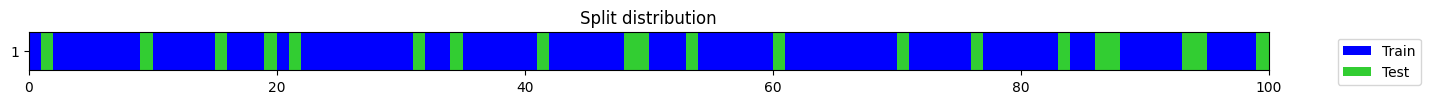

((#80) [90,43,50,35,2,26,88,36,39,28...],
 (#20) [83,34,60,49,21,41,53,94,15,19...])

In [21]:
# Split ps_am_rp so that different simulations are used in train and validation
splits = get_splits(ps_am_rp)
splits

In [23]:
X_train, y_train = apply_sliding_window_3d(ps_am_rp[splits[0]], 
                                           window_len=config.lookback, 
                                           horizon=config.horizon, 
                                           stride=config.stride, 
                                           seq_first=False)
X_valid, y_valid = apply_sliding_window_3d(ps_am_rp[splits[1]], 
                                           window_len=config.lookback,
                                           horizon=config.horizon, 
                                           stride=config.stride,
                                           seq_first=False)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((400, 3564, 12), (400, 3564, 12), (100, 3564, 12), (100, 3564, 12))

In [24]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
X.shape, y.shape, splits

((500, 3564, 12),
 (500, 3564, 12),
 ((#400) [0,1,2,3,4,5,6,7,8,9...],
  (#100) [400,401,402,403,404,405,406,407,408,409...]))

In [25]:
#batch_tfms=[TSStandardize()]
batch_tfms=[]
learn = TSForecaster(X, y, splits, bs=[config.bs, 2*config.bs], batch_tfms=batch_tfms,
                     seed=config.seed, arch='TSiTPlus', arch_config=dict())
lr_max = learn.lr_find(suggest_funcs=(valley, steep)).steep if config.lr_max is None else config.max_lr
print(f"#params: {sum(p.numel() for p in learn.model.parameters())}")
learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=lr_max)
learn.plot_metrics()

KeyboardInterrupt: 